# The work energy does for us

The standard of life Swiss people enjoy is amazing. A big part of this is probably due to the usage of large amounts of energy. But how much work is truly at our disposal thanks to this?

In [1]:
import pandas as pd
import argparse

Convert from kilo-calories used to measure human energy consumption to kWh used to measure the consumption of electrical energy

In [2]:
def kcal_to_kwh(kcal):
    joule = kcal * 1000 * 4.1868
    return joule / (3.6 * 10**6)

Source:
* https://en.wikipedia.org/wiki/Conversion_of_units#Energy

## Setup

In [3]:
parser = argparse.ArgumentParser(description='How many people would have to work for a typical Swiss energy comsumption')
parser.add_argument("--weight", help="Weight (kg)", default=80, type=int)
parser.add_argument("--height", help="Height (cm)", default=180, type=int)
parser.add_argument("--age", help="Age (years)", default=30, type=int)
parser.add_argument("--sex", help="Sex (m|f)", default="m", type=str)
parser.add_argument("--activity", help="Type of activity", default="multiple household tasks all at once, moderate effort", type=str)
parser.add_argument("--hours", help="Hours of work", default=8, type=float)
parser.add_argument("-f", help="For jupyter")
args = parser.parse_args()


weight_kg = args.weight
height_cm = args.height
age_years = args.age
sex = args.sex
activity = args.activity
work_hours = args.hours


## Resting Energy Expenditure (REE) in kcal

In [4]:
def resting_energy_expenditure(weight_kg, height_cm, age_years, sex):
    if sex == "m":
        expenditure = 10*weight_kg+6.25*height_cm-5*age_years+5
    elif sex == "f":
        expenditure = 10*weight_kg+6.25*height_cm-5*age_years-161
    return expenditure

resting_energy_expenditure(weight_kg, height_cm, age_years, sex)

1780.0

Source:
* Mifflin, M. D., St Jeor, S. T., Hill, L. A., Scott, B. J., Daugherty, S. A., & Koh, Y. O. (1990). A new predictive equation for resting energy expenditure in healthy individuals. The American journal of clinical nutrition, 51(2), 241-247.

Not used:
* Bouchard, Claude, et al. "A method to assess energy expenditure in children and adults." The American journal of clinical nutrition 37.3 (1983): 461-467.
* Ravussin, Eric, et al. "Determinants of 24-hour energy expenditure in man. Methods and results using a respiratory chamber." The Journal of clinical investigation 78.6 (1986): 1568-1578.

## Activity factor: Metabolic Equivalent (MET)

The MET describes how much more energy is expended when doing a certain activity compared to doing nothing (MET of 1.0). For example:

* Sitting/eating: 1.5
* Cleaning: 3.3
* Soccer: 7

We use the mean of the MET's in an activity category. For example:

* Inactivity: 1.3
* Housework ("home"): 3.5

In [5]:
def activity_factor(activity):
    df = pd.read_csv('MET_intensities.csv', sep=";",)
    pd.to_numeric(df.METS)
    return df[df['SPECIFIC ACTIVITIES'].str.contains(activity)].METS

In [6]:
activity_factor(activity).mean()

3.5

Source:
* Ainsworth, B. E., Haskell, W. L., Herrmann, S. D., Meckes, N., Bassett Jr, D. R., Tudor-Locke, C., ... & Leon, A. S. (2011). 2011 Compendium of Physical Activities: a second update of codes and MET values. Medicine & science in sports & exercise, 43(8), 1575-1581.

Alternative to MET: Physical Activity Rates (PAR). The PAR-scores are pretty similar to the MET.

* Eating/drinking: 1.4–1.6
* Housework: 2.8
* Football: 8

Sources:

* Vaz, M., Karaolis, N., Draper, A., & Shetty, P. (2005). A compilation of energy costs of physical activities. Public health nutrition, 8(7a), 1153-1183.
* http://www.fao.org/docrep/007/y5686e/y5686e0e.htm

To calculate the amount of energy that is actually used for work, we subtract the REE. There are two methods:

* Ainsworth et al. describe how the energy expenditure can directly be calculated from the MET-score and the weight with this formula: 

$$kilocalories = MET \times  weight\ in\ kilograms \times duration\ in\ hours$$

* To get more individualized values, we could first calculate the Resting Energy Expenditure or Base Metabolic Rate (BMR) by Mifflin et al. and multiply it with the MET-score:

$$kilocalories = \frac{REE \times MET \times duration\ in\ hours}{24}$$

In [7]:
kcal_ainsworth = activity_factor(activity).mean() * weight_kg * work_hours

kcal_mifflin_young = (resting_energy_expenditure(weight_kg, 180, 20, "m") \
               * activity_factor(activity).mean() * work_hours) / 24

kcal_mifflin_old = (resting_energy_expenditure(weight_kg, 180, 70, "m") \
               * activity_factor(activity).mean() * work_hours) / 24

kcal_mifflin = (resting_energy_expenditure(weight_kg, height_cm, age_years, sex) \
               * activity_factor(activity).mean() * work_hours) / 24 # we will use this later

print(
    " % difference for young men:", 100*(kcal_ainsworth - kcal_mifflin_young)/kcal_ainsworth, "\n",
    "% difference for old men:", 100*(kcal_ainsworth - kcal_mifflin_old)/kcal_ainsworth,
)

 % difference for young men: 4.6875 
 % difference for old men: 17.7083333333


The formula proposed by Ainsworth et al. is simpler but it seems to err on the high side. We will therefore use the formula based on the REE.

## Power output

We now have a way to calculate the energy use of the metabolism based on the type of phyiscal activity. Yet not all of this energy can be converted in outwards work. Luckily the MET-score table has some entries which calculate the MET for a given power output on a bycicle. We would like to find out the relationship between a MET-score and the power output:

In [8]:
df = pd.read_csv('MET_intensities.csv', sep=";",)
pd.to_numeric(df.METS)

#MET_power_proportions = 
watts_METS = pd.DataFrame([
    [40, df[df['SPECIFIC ACTIVITIES'].str.contains('30-50 watts')].METS.iloc[0]],
    [70, df[df['SPECIFIC ACTIVITIES'].str.contains('51-89 watts')].METS.iloc[0]],
    [95, df[df['SPECIFIC ACTIVITIES'].str.contains('90-100 watts')].METS.iloc[0]],
    [130, df[df['SPECIFIC ACTIVITIES'].str.contains('101-160 watts')].METS.iloc[0]],
    [180, df[df['SPECIFIC ACTIVITIES'].str.contains('161-200 watts')].METS.iloc[0]],
    [235, df[df['SPECIFIC ACTIVITIES'].str.contains(' 201-270 watts')].METS.iloc[0]],
],
columns= ['Watts', 'METS'])
watts_METS.plot.line(x='Watts', y='METS')

Visibly the relationship between METs and output power in watts is pretty much linear. We can therefore use a ratio to convert from one to the other. We take the mean ratio from the above six entries.

In [9]:
def METS_to_watts(METS):
    ratios = []
    for entry in watts_METS.values:
        ratios.append(entry[0]/entry[1])
    ratio = pd.DataFrame(ratios).mean()[0]
    return METS * ratio

Source:
* Ainsworth, B. E., Haskell, W. L., Herrmann, S. D., Meckes, N., Bassett Jr, D. R., Tudor-Locke, C., ... & Leon, A. S. (2011). 2011 Compendium of Physical Activities: a second update of codes and MET values. Medicine & science in sports & exercise, 43(8), 1575-1581.

## Daily performance of a worker

With this we can calculate how much work in kWh one person can deliver per day (depending only on work hours and actvity factor).

In [10]:
work_output_kwh_day = work_hours * METS_to_watts(activity_factor(activity).mean()) / 1000
print("Performance (kWh/day):", work_output_kwh_day)

Performance (kWh/day): 0.410221330957


## Efficiency of a worker

As mentioned above, not all the energy that the metabolism uses is transformed into work. With the above results we can calculate the efficiency of a worker:

In [11]:
efficiency = work_output_kwh_day / kcal_to_kwh(kcal_mifflin)
print("Efficiency (%): ", 100*efficiency )

Efficiency (%):  16.9852417555


We verify this score based on another paper and another means of calculation. Hagerman et al. found that the mean maximum energy produced on a training bycicle was 207 watts. Here we use the direct formula proposed by Ainsworth et al. and the highest MET-score for "bycicling"  

In [12]:
cycling = weight_kg * activity_factor('bicycling').max() * 1 
internal_kWh = kcal_to_kwh(cycling)
external_kWh = 207 / 1000
proportion = external_kWh / internal_kWh
print("Efficiency (%): ", 100*proportion )

Efficiency (%):  13.9053095443


The two values are encouragingly close. An efficiency of around 15% is therefore probably close to reality.

Sources:
* Hagerman, F. C., Lawrence, R. A., & Mansfield, M. C. (1988). A comparison of energy expenditure during rowing and cycling ergometry. Medicine and science in sports and exercise, 20(5), 479-488.

## Annual total energy consumption of a Swiss person

We move on to see how much energy a typical Swiss person uses and how many persons would need to werk for her to replace this work.

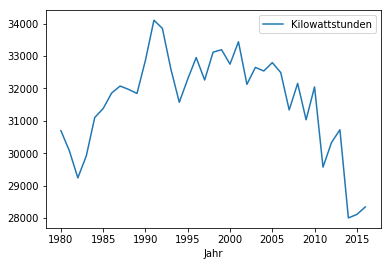

In [13]:
def energy_use_per_capita(year):
    df = pd.read_csv('endenergieverbrauch.csv', sep=";",)
    return df[df.Jahr == year].Kilowattstunden.iloc[0]

pd.read_csv('endenergieverbrauch.csv', sep=";").plot(x='Jahr', y='Kilowattstunden')

We use data from the Swiss Federal Office of Statistics for this. It contains a timeseries of total energy consumption per capita since 1980. As we can see, it has peaked in the 1990s and is no in decline.

Source:
* https://www.bfs.admin.ch/bfs/de/home/statistiken/nachhaltige-entwicklung/monet/alle-nach-themen/energie-klima/endenergieverbrauch.html

In [14]:
print(energy_use_per_capita(2016), "kWh")

28341 kWh


## Workers needed to replace this consumption

If we couldn't rely on all our energy sources and would have to employ people instead, how many would we need? We can use the daily performance of a worker calculated above to find out: 

In [15]:
energy_used_kWh_day = energy_use_per_capita(2016) / 365
energy_used_kWh_day

77.646575342465752

In [16]:
nb_workers = energy_used_kWh_day / work_output_kwh_day
print("Number of employees needed: ", nb_workers)

Number of employees needed:  189.279711909


## Workers for needed in a 2000-watt society

In the 2000-watt society promoted as the sustainable perspecitve by the governement, each person would only us 48 kWh per day instead of 78. That makes less workers but still an impressive number 

In [17]:
future_kWh_day = 2 * 24
nb_workers_future = future_kWh_day / work_output_kwh_day
print("Number of employees needed: ", nb_workers_future)

Number of employees needed:  117.010005033


## Conclusion

In any case, it is impressive how much human labor has been saved due to the use of energy sources. It only shows how valuable they are. Thanks to them we can all live a life only a king/queen could afford in the past.

In [19]:
print(work_output_kwh_day)

0.410221330957


## See also
* [The Toaster Challenge, "Olympic Cyclist Vs. Toaster: Can He Power It?", Youtube](https://www.youtube.com/watch?v=S4O5voOCqAQ)